![time.png](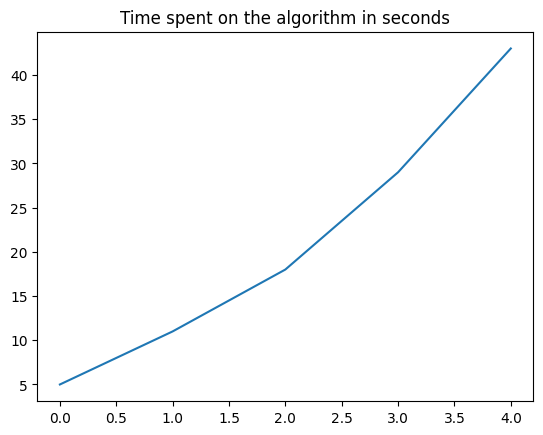![time.png](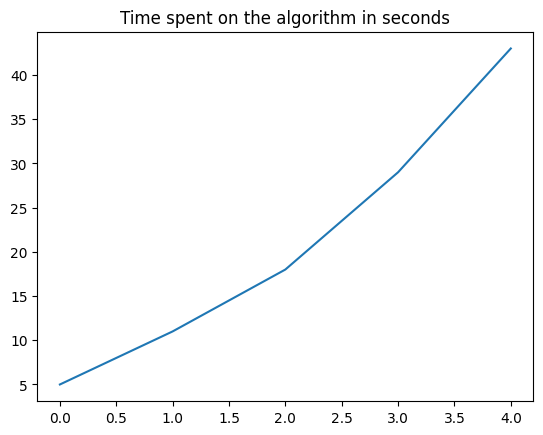![6.png](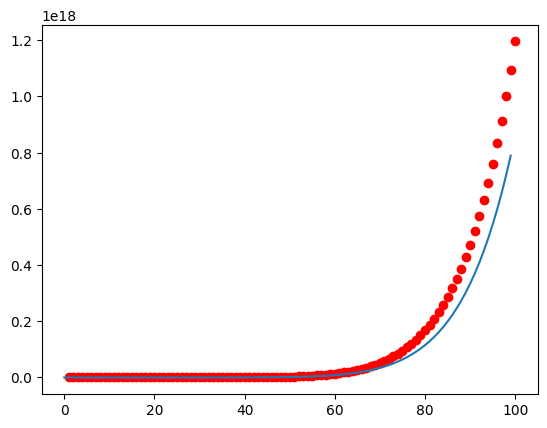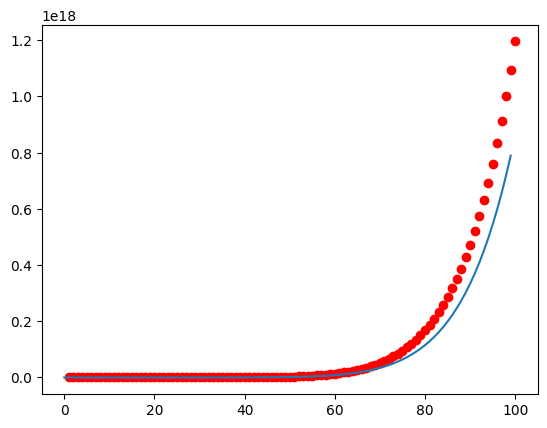)))

# Seminar 1: Genetic Programming for Symbolic Regression


In [2]:
import random
import pandas as pd
import math
from matplotlib import pyplot as plt

In [ ]:
dataset = pd.read_csv("dataset.csv")
dataset

In [4]:
idx = 6
xs = dataset['Xs'].iloc[idx]
ys = dataset['Ys'].iloc[idx]
equation = dataset['Equation'].iloc[idx]

So far we've loaded the database and extracted the x and y values for the first entry. For the purposes of the defence I've also explicitly declared the variables xs and ys to be the same as the first entry, so loading the data onto google colabs is not needed. The equation is also extracted to compare with the solution.

## Representation

I've decided to implement a solution that return a polynomial that approximates the given points. Since the scope is limited to polynomials we can forgo the tree and represent the function using an array. The elements of the array are coefficients of the polynomial, starting with the lowest exponent and ending in the highest.

Example: [1, 2, 0, -3] is equivalent to 1 + x^2 -3x^4

The following snippet of code is used to print the polynomial as a string and is used later to compare the solution.

In [5]:
def print_polynomial(polynomial):
  result = ""
  for i in range(len(polynomial)):
    if polynomial[i] == 0:
      continue
    else:
      if i == 0:
        result += "{c}".format(c = polynomial[0])
      else:
        if polynomial[i] > 0:
          s = "+"
        else:
          s = ""
        result += " " + s + "{c}x^{e}".format(c = polynomial[i], e = i)

  print(result)

## The algorithm

First we need to define the functions for testing the fitness, crossover and mutation. Then we need to generate the population.

Mutating the polynomial is simple. Once a polyinomial is selected for mutation the function first randomly chooses the amount and which coefficients will get changed. After that it changes the chosed coefficients like this:


*   20% chance to make the coefficient 0 (unless it's the term with the highest exponent)
*   30% chance to make the coefficient a fraction
*   50% chance to make the coefficient a nonzero integer

In [6]:
def mutation(polynomial):
    amount = random.randint(1, len(polynomial))
    to_change = random.sample(range(0, len(polynomial)), amount)

    for idx in to_change:
        coef = 0
        rand = random.uniform(0, 1)
        if rand < 0.2 and idx != len(polynomial) - 1:
            coef = 0
        elif rand < 0.5:
            coef = random.choice([j for j in range(-10, 11) if j != 0]) / random.choice(range(1, 11))
        else:
            coef = random.choice([j for j in range(-10, 11) if j != 0])

        polynomial[idx] = coef

    return polynomial

The crossover function simply swaps the last term of the polynomials. The results without the crossover were already decent, with the last term being the most problematic. So I've decided that the crossover should only change this one.

For most functions as the x approaches 100 the first term is less and less relevant, but it does improve the accuracy around the origin.

Candidates for crossover are selected with a tournament selection algorithm.

In [ ]:
def crossover(poly1, poly2):
    temp = poly1[0]
    poly1[0] = poly2[0]
    poly2[0] = temp
    return poly1, poly2



def tournament(pop, t, num_parents):
    parents = []

    for i in range(num_parents):
        indexes = random.sample(range(len(pop)), t)
        competitors = [pop[j] for j in indexes]
        competitors = sorted(competitors, key=lambda x: x[1], reverse=True)

        parents.append(competitors[0])

    return parents

The fitness function computes the least squares difference between the values returned by the polynomial and the outputs from the database.

In [7]:
def evaluate(poly, val):
    total = 0
    for i in range(len(poly)):
        total += poly[i] * val**i
    return total


def fitness(poly):
    total = 0
    for i in range(len(xs)):
        total += (evaluate(poly, xs[i]) - ys[i])**2
    return - math.sqrt(total)

The last step in the preparation is to generate the population.

In [8]:
def generate_polynomial():
    degree = random.choice(range(1, 31))
    polynomial = []
    for i in range(degree + 1):
        rand = random.uniform(0, 1)
        if rand < 0.2 and i != degree:
            coef = 0
        elif rand < 0.5:
            coef = random.choice([j for j in range(-10, 11) if j != 0]) / random.choice(range(1, 11))
        else:
            coef = random.choice([j for j in range(-10, 11) if j != 0])

        polynomial.append(coef)

    return polynomial


pop = []
for i in range(100):
    temp = generate_polynomial()
    pop.append([temp, 0.])

Now we can execute the algorithm. The result is the array pop with the candidates sorted by the fitness descending (since the fitness result is a negative number, the absolute value is ascending). Thus the solution is the first element of the array.


In [10]:
num_generations = 300
num_parents = 20
mutation_probability = 0.2

for i in range(num_generations):
    # fitness computation
    for j in range(len(pop)):
        pop[j][1] = fitness(pop[j][0])
    pop = sorted(pop, key=lambda x: x[1], reverse=True)

    # crossover
    children = []
    parents = tournament(pop, 10, num_parents)
    for j in range(num_parents // 2):
        parent1 = random.choice(parents)
        parents.remove(parent1)
        parent2 = random.choice(parents)
        parents.remove(parent2)
        pop.remove(parent1)
        if parent2 in pop:
          pop.remove(parent2)
        child1, child2 = crossover(parent1, parent2)
        pop.append(child1)
        pop.append(child2)

    # mutation
    for j in range(5, len(pop) - 1):
        if random.uniform(0, 1) <= mutation_probability:
            pop[j][0] = mutation(pop[j][0])

for j in range(len(pop)):
    pop[j][1] = fitness(pop[j][0])
pop = sorted(pop, key=lambda x: x[1], reverse=True)

TypeError: ignored

## Results

In the end all that's left is to print and display the solution.

In [ ]:
print_polynomial(pop[0][0])
print()

outputs = []
for i in range(len(xs)):
  outputs.append(evaluate(pop[0][0], xs[i]))

plt.plot(xs, ys, 'ro')
plt.plot(outputs)

Increasing the number of generations is the change that results in the highest increase in the computatinal time. Here are the results of the execution of the algorithm with 100, 200, 300, 400 and 500 generations. Note that the time needed is not constant as it was run on Google colabs using a free plan, so the available computational resources are not constant.

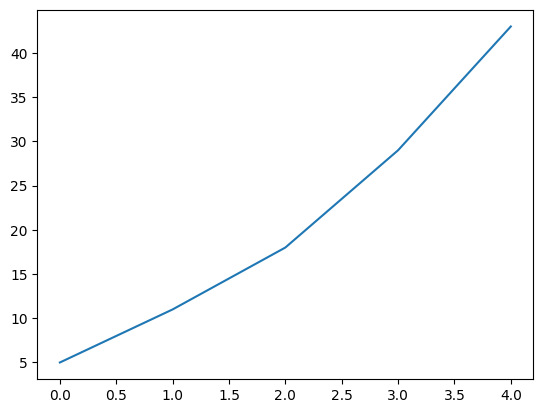

Increasing the mutation chance results in bigger differences in the results since it begins to approach random search. On the other hand reducing the parameter too much results in a drop of the accuracy of the results since the population remains mostly the same.

Changing the amount of parents reproducing has yielded the highest increase in accuracy of the result while having had next to no impact on the execution time.

Results for the 7th, 48th, 72nd and 89 entry.

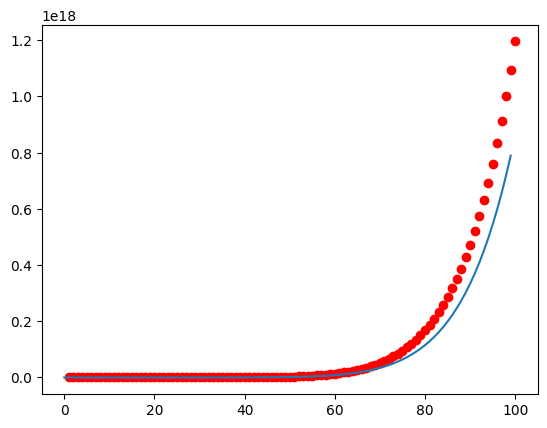

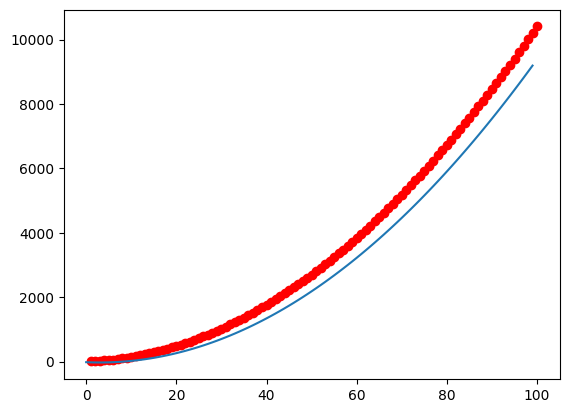

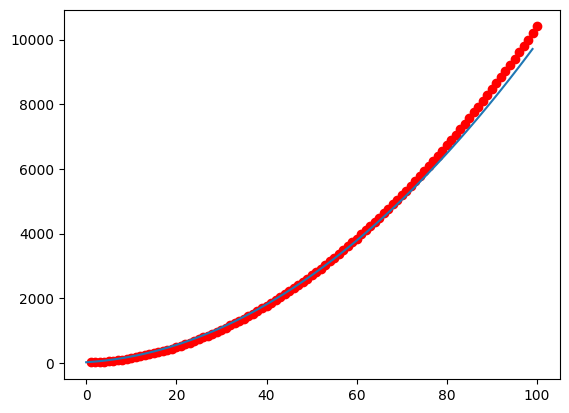

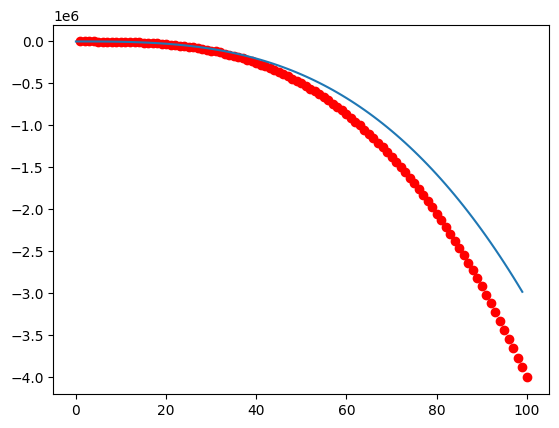